In [546]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import math
import zipfile
import os
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
seed = 42
torch.random.manual_seed(seed)

batch_size = 256
lr = 1e-3
epochs = 200

root_path = "/Users/asandeistefan/Downloads"
EVALUATION = True

# Data preparation

In [548]:
def load_data(csv_path: str) -> Tuple[np.ndarray, np.ndarray]:
    ttheta = pd.read_csv(csv_path)
    t = np.array(ttheta["t"])
    theta = np.array(ttheta["theta"])
    return t, theta

In [549]:
def split_data(t: np.ndarray, theta: np.ndarray, threshold=1):
    # split data in two sections: before the force F is applied, and after
    theta_1, t_1 = [], []
    theta_2, t_2 = [], []
    force_flag = False

    t_1.append(t[0])
    theta_1.append(theta[0])
    for i in range(1, len(t)):
        if t[i] - t[i - 1] < threshold:  #
            if not force_flag:
                t_1.append(t[i])
                theta_1.append(theta[i])
            else:
                t_2.append(t[i])
                theta_2.append(theta[i])
        else:
            force_flag = True
            t_2.append(t[i])
            theta_2.append(theta[i])

    return np.array(t_1), np.array(theta_1), np.array(t_2), np.array(theta_2)

In [550]:
def get_next_zerotheta_timestamp(t, theta):
    # To find the next zero point.
    timestamp = 0
    for i in range(1, len(theta)):
        if theta[i - 1] * theta[i] < 0:
            timestamp = t[i]
            break
    return timestamp


def theta_func(thetaomega, t, alpha, beta):
    # Function for solving differential equations.
    theta, omega = thetaomega
    a = -alpha * omega - beta * math.sin(theta)
    return np.array([omega, a])


def derivative(t, theta):
    dthetadt = (theta[1:] - theta[:-1]) / (t[1:] - t[:-1])
    return dthetadt


def get_break_timestamp(
    break_t, theta_1_forward, theta_2_backward
):  
    # Find the moment when F disappears by identifying the intersection point of the curves.
    min_val = math.inf
    min_idx = 0
    for i in range(len(break_t) - 1):
        val = abs(theta_1_forward[i] - theta_2_backward[i])
        dtheta_1 = theta_1_forward[i + 1] - theta_1_forward[i]
        dtheta_2 = theta_2_backward[i + 1] - theta_2_backward[i]
        val += abs((dtheta_1 - dtheta_2) / (break_t[i + 1] - break_t[i]))
        if val < min_val:
            min_val = val
            min_idx = i

    return break_t[min_idx]


def plot1d_full_data(
    t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp
):
    fig = plt.figure()

    ax = fig.add_subplot()
    ax.plot(t_1, theta_1, lw=1, color="blue")
    ax.plot(t_2, theta_2, lw=1, color="blue")
    ax.plot(break_t, theta_break, lw=1, color="red")
    ax.scatter(
        [break_timestamp], [theta_break[break_t == break_timestamp]], s=20, color="red"
    )

    plt.show()
    plt.cla()
    plt.close("all")

In [551]:
def reconstruct_missing_segment(t_1, theta_1, t_2, theta_2, alpha, beta):
    # initial conditions
    theta0 = theta_1[-1]
    omega0 = (theta_1[-1] - theta_1[-2]) / (t_1[-1] - t_1[-2])
    thetaomega0 = [theta0, omega0]

    break_t = np.linspace(t_1[-1], t_2[0], 200)
    thetaomega_sol = odeint(theta_func, thetaomega0, break_t, args=(alpha, beta))
    theta_break = thetaomega_sol[:, 0]

    # find return to zero
    break_timestamp = get_next_zerotheta_timestamp(break_t, theta_break)

    return break_t, theta_break, break_timestamp

In [552]:
if not EVALUATION:
    t, theta = load_data(f"{root_path}/pendulum_train.csv")
    t_1, theta_1, t_2, theta_2 = split_data(t, theta)

let's do a vizualization of the task

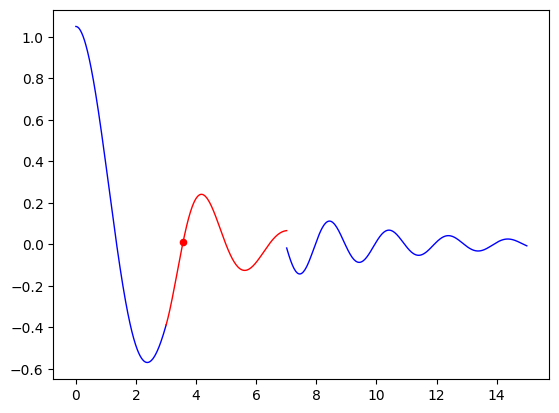

In [553]:
if not EVALUATION:
    # dummy parameters (to be regressed later) - just guessed them
    alpha, beta = 0.9, 5 #0.5, 18.5

    break_t, theta_break, break_timestamp = reconstruct_missing_segment(
        t_1, theta_1, t_2, theta_2, alpha, beta
    )

    plot1d_full_data(
        t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp
    )

# Model

The theoretical basis for the model is the acceleration formula: 

$$\frac{\mathrm{d}^2 \theta}{\mathrm{d} t^2} = - \alpha \frac{\mathrm{d} \theta}{\mathrm{d} t} - \beta \sin \theta(t)$$

where $\alpha = \frac{\mu}{m}$ and $\beta = \frac{g}{l}$. After $t_{F put}$, an external force is applied and the $\beta$ parameter becomes $\frac{g}{l} + \frac{F}{m l}$.

The model has to approximate the length $l$, the air resistance $\mu$, the magnitude of the external force $F$. We know that $m=1$ and $g=9.8$.

In [554]:
class SinglePendulum(nn.Module):
    def __init__(self):
        super().__init__()

        self.l = nn.Parameter(torch.randn((1,), requires_grad=True))
        self.mu = nn.Parameter(torch.randn((1,), requires_grad=True))
        self.F = nn.Parameter(torch.randn((1,), requires_grad=True))

        self.g = 9.18
        self.m = 1

    def get_alphabeta(self, add_force=False):
        alpha = self.mu / self.m
        beta = 0

        if add_force:
            beta = self.g / self.l
        else:
            beta = self.g / self.l + self.F / (self.m * self.l)

        return alpha, beta

    def forward(self, theta, omega, add_force=False):
        alpha, beta = self.get_alphabeta(add_force)

        a = -alpha * omega - beta * torch.sin(theta)
        return a

In [555]:
pendulum = SinglePendulum()

# takes in theta(t) and omega(t)=theta'(t)
pendulum(torch.tensor(0.1), torch.tensor(0.2))

tensor([-2.8173], grad_fn=<SubBackward0>)

# Training

In [556]:
if not EVALUATION:
    # Compute omega and alpha using finite differences
    theta_t = theta_break
    t_t = break_t

    omega_t = (theta_t[1:] - theta_t[:-1]) / (t_t[1:] - t_t[:-1])
    alpha_t = (omega_t[1:] - omega_t[:-1]) / (t_t[2:] - t_t[1:-1])

    # Shorten theta and omega accordingly to match alpha shape
    theta_t = theta_t[1:-1]
    omega_t = omega_t[:-1]

    # Convert to torch tensors
    theta_tensor = torch.tensor(theta_t, dtype=torch.float32)
    omega_tensor = torch.tensor(omega_t, dtype=torch.float32)
    alpha_tensor = torch.tensor(alpha_t, dtype=torch.float32)

    # Create the Dataloader
    dataset = TensorDataset(theta_tensor, omega_tensor, alpha_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [557]:
def train(model, epochs, lr):
    optimizer = AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0.0
        for theta_batch, omega_batch, alpha_batch in loader:
            pred_alpha = model(theta_batch, omega_batch, add_force=True).squeeze()
            loss = F.mse_loss(pred_alpha, alpha_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(theta_batch)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.6f}")

In [558]:
if not EVALUATION:
    train(pendulum, epochs, lr)

Epoch 100, Loss: 6.114309
Epoch 200, Loss: 4.239481


In [559]:
print(f"Estimated length l: {pendulum.l.item():.4f}")
print(f"Estimated air resistance mu: {pendulum.mu.item():.4f}")
print(f"Estimated force F: {pendulum.F.item():.4f}")

Estimated length l: 0.4864
Estimated air resistance mu: 0.3107
Estimated force F: 0.2345


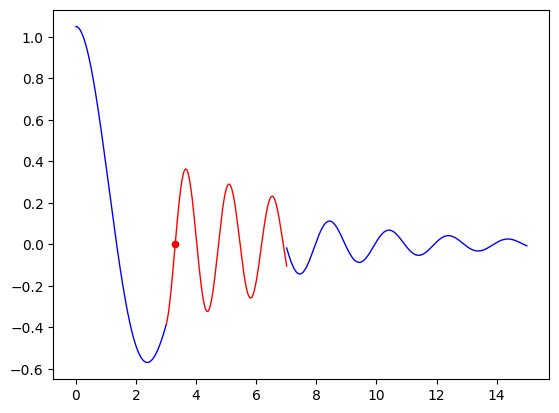

In [560]:
if not EVALUATION:
    alpha, beta = pendulum.get_alphabeta(add_force=False)
    alpha, beta = alpha.item(), beta.item()

    break_t, theta_break, break_timestamp = reconstruct_missing_segment(
        t_1, theta_1, t_2, theta_2, alpha, beta
    )

    plot1d_full_data(t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp)

# Submission

In [ ]:
def estimate_and_save_parameters(csv_path: str, submission_path: str):
    t, theta = load_data(csv_path)
    t_1, theta_1, t_2, theta_2 = split_data(t, theta)

    # Dummy model to extract parameters
    model = SinglePendulum()
    break_t, theta_break, _ = reconstruct_missing_segment(
        t_1, theta_1, t_2, theta_2, alpha=0.9, beta=5
    )

    # Derivatives
    omega_t = (theta_break[1:] - theta_break[:-1]) / (break_t[1:] - break_t[:-1])
    alpha_t = (omega_t[1:] - omega_t[:-1]) / (break_t[2:] - break_t[1:-1])
    theta_t = theta_break[1:-1]
    omega_t = omega_t[:-1]

    # Torch training data
    theta_tensor = torch.tensor(theta_t, dtype=torch.float32)
    omega_tensor = torch.tensor(omega_t, dtype=torch.float32)
    alpha_tensor = torch.tensor(alpha_t, dtype=torch.float32)

    loader = DataLoader(
        TensorDataset(theta_tensor, omega_tensor, alpha_tensor),
        batch_size=256,
        shuffle=True,
    )

    # Train model
    optimizer = AdamW(model.parameters(), lr=1e-3)
    for epoch in range(2000):
        for theta_b, omega_b, alpha_b in loader:
            pred = model(theta_b, omega_b, add_force=True).squeeze()
            loss = F.mse_loss(pred, alpha_b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Extract parameters
    l = model.l.item()
    mu = model.mu.item()
    Force = model.F.item()

    # Final forward sim and timestamps
    alpha, beta = model.get_alphabeta(add_force=False)
    break_t, theta_break, t_nextzerotheta = reconstruct_missing_segment(
        t_1, theta_1, t_2, theta_2, alpha.item(), beta.item()
    )
    t_Fput = t_2[0]

    pd.DataFrame([{
        "l": l,
        "miu": mu,
        "F": Force,
        "t_nextzerotheta": t_nextzerotheta,
        "t_Fput": t_Fput,
    }]).to_csv(submission_path, index=False)

In [562]:
TRAIN_PATH = "/bohr/train-08bw/v1/" if EVALUATION else f"{root_path}/"
estimate_and_save_parameters(
    csv_path=TRAIN_PATH + "pendulum_train.csv", submission_path="submission_train.csv"
)  # Solve the training set equation.

In [563]:
# Load the test set
# “DATA_PATH” is an environment variable for the encrypted test set.
# After submission, the test set can be accessed for system scoring in the following manner, but the participants cannot download it directly.
if os.environ.get("DATA_PATH"):
    DATA_PATH = os.environ.get("DATA_PATH") + "/"

    estimate_and_save_parameters(
        csv_path=DATA_PATH + "pendulum_testA.csv", submission_path="submissionA.csv"
    )  # Solve the equation for the Public test set （test set A）.
    estimate_and_save_parameters(
        csv_path=DATA_PATH + "pendulum_testB.csv", submission_path="submissionB.csv"
    )  # Solve the equation for the Private test set （test set B）.

    # Define the files to be packaged and the compressed file name.
    files_to_zip = ["submissionA.csv", "submissionB.csv"]
    zip_filename = "submission.zip"

    # Create a zip file.
    with zipfile.ZipFile(zip_filename, "w") as zipf:
        for file in files_to_zip:
            # Add files to the zip file.
            zipf.write(file, os.path.basename(file))

    print(f"{zip_filename} is created successfully!")
else:
    print(
        "When the baseline is running, this error message will appear because the test set cannot be read, which is a normal phenomenon."
    )

When the baseline is running, this error message will appear because the test set cannot be read, which is a normal phenomenon.
